# Analysis of TCGA database through GDC

## 1. Initial settings and import libraries

In [2]:
#set working directry
setwd("/Users/csi16/Desktop/cbioinformatics/200407-/TCGA")

#import libraries
require(edgeR)
require(ComplexHeatmap)
require(gprofiler2)

Loading required package: edgeR

Loading required package: limma

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


Loading required package: gprofiler2



## 2. Sample information

In [79]:
sample_information <- read.delim(
  "gdc_sample_sheet.2020-04-15.tsv",
  stringsAsFactor=FALSE,
  header = TRUE)
FileID <- sample_information$File.ID
FileName <- sample_information$File.Name
SampleType <- sample_information$Sample.Type
NofSample <- length(FileID)

## 3. Create dataframe

In [80]:
all.data <- data.frame(NA)
colnames(all.data) <- c("gene")
for (i in 1:NofSample){
  FilePath <- paste("data", FileID[i], FileName[i], sep = "/")
  temp <- read.delim(
    FilePath,
    stringsAsFactor=FALSE,
    header = FALSE)
  colnames(temp) <- c("gene",i)
  all.data <- merge(all.data, temp, all=T)
}
all.data <- all.data[-nrow(all.data),]
all.data <- all.data[-(1:5),]
rownames(all.data) <- all.data[,1]
all.data <- all.data[,-1]

## 4. Remove "Reccurent Tumor"

In [81]:
unique(SampleType)
RTindex <- which(SampleType == "Recurrent Tumor")
FileName <- FileName[-RTindex]
SampleType <- SampleType[-RTindex]
all.data <- all.data[,-RTindex]

[1] "Primary Tumor"       "Solid Tissue Normal" "Recurrent Tumor"

## 5. Normalization (cpm)

In [82]:
obj <- as.logical(rowSums(all.data) > 0)
all.data <- all.data[obj,]
mil <- 1000000
nf <- mil/colSums(all.data)
all.data_cpm <- sweep(all.data, 2, nf, "*")

## 6. Clustering

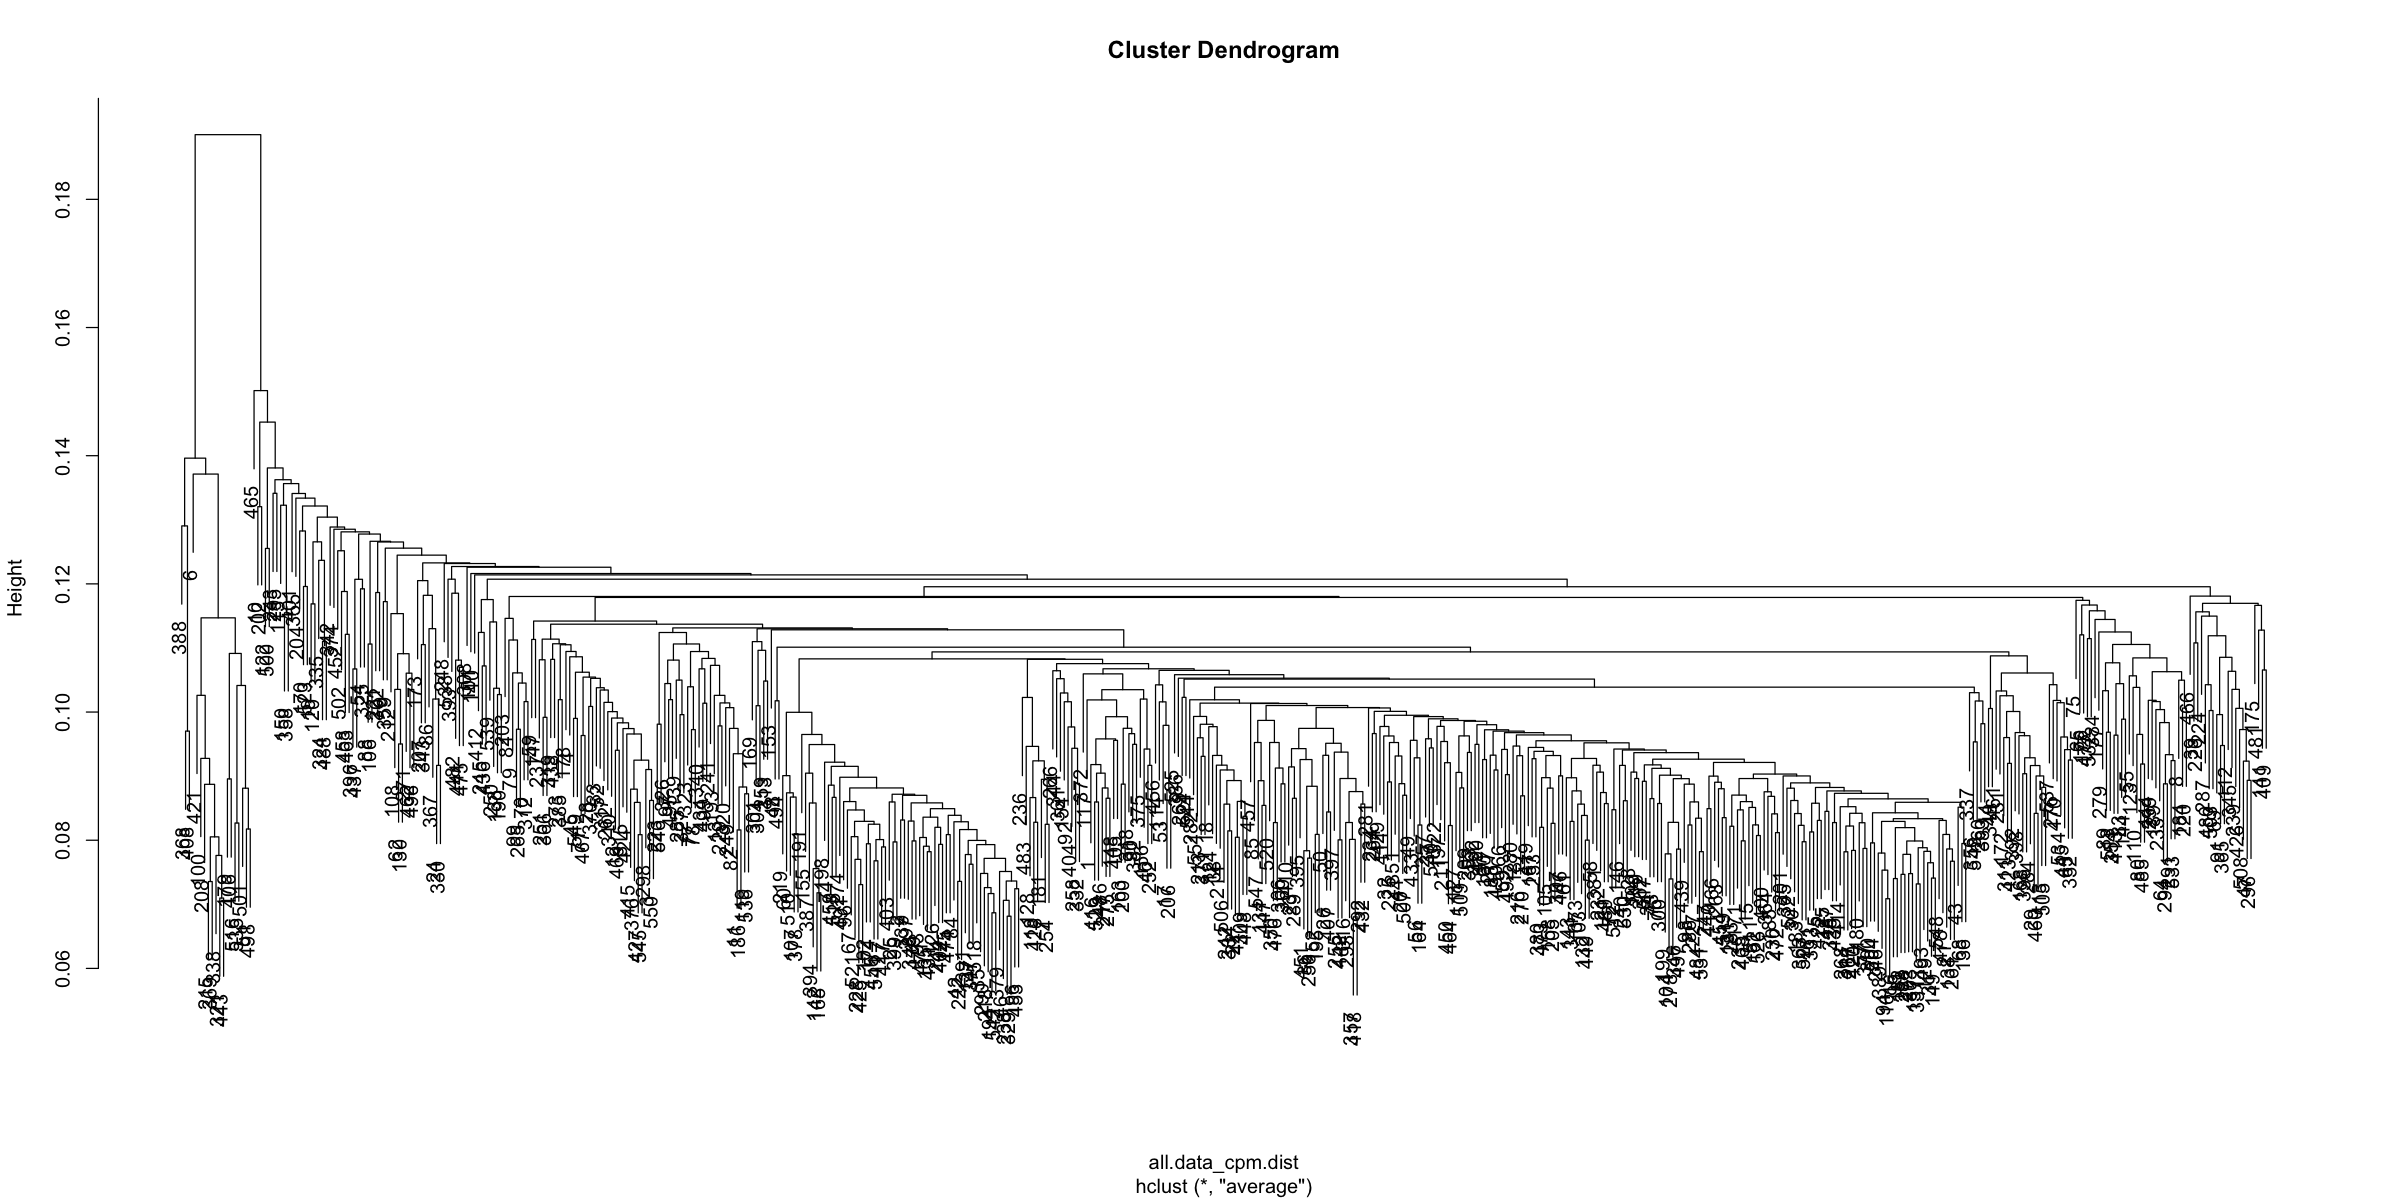

In [83]:
all.data_cpm.dist <- as.dist(1 - cor(all.data_cpm, method = "spearman"))
out_cluster <- hclust(all.data_cpm.dist, method = "average")
options(repr.plot.width = 20, repr.plot.height = 10)
plot(out_cluster)

## 7. PCA

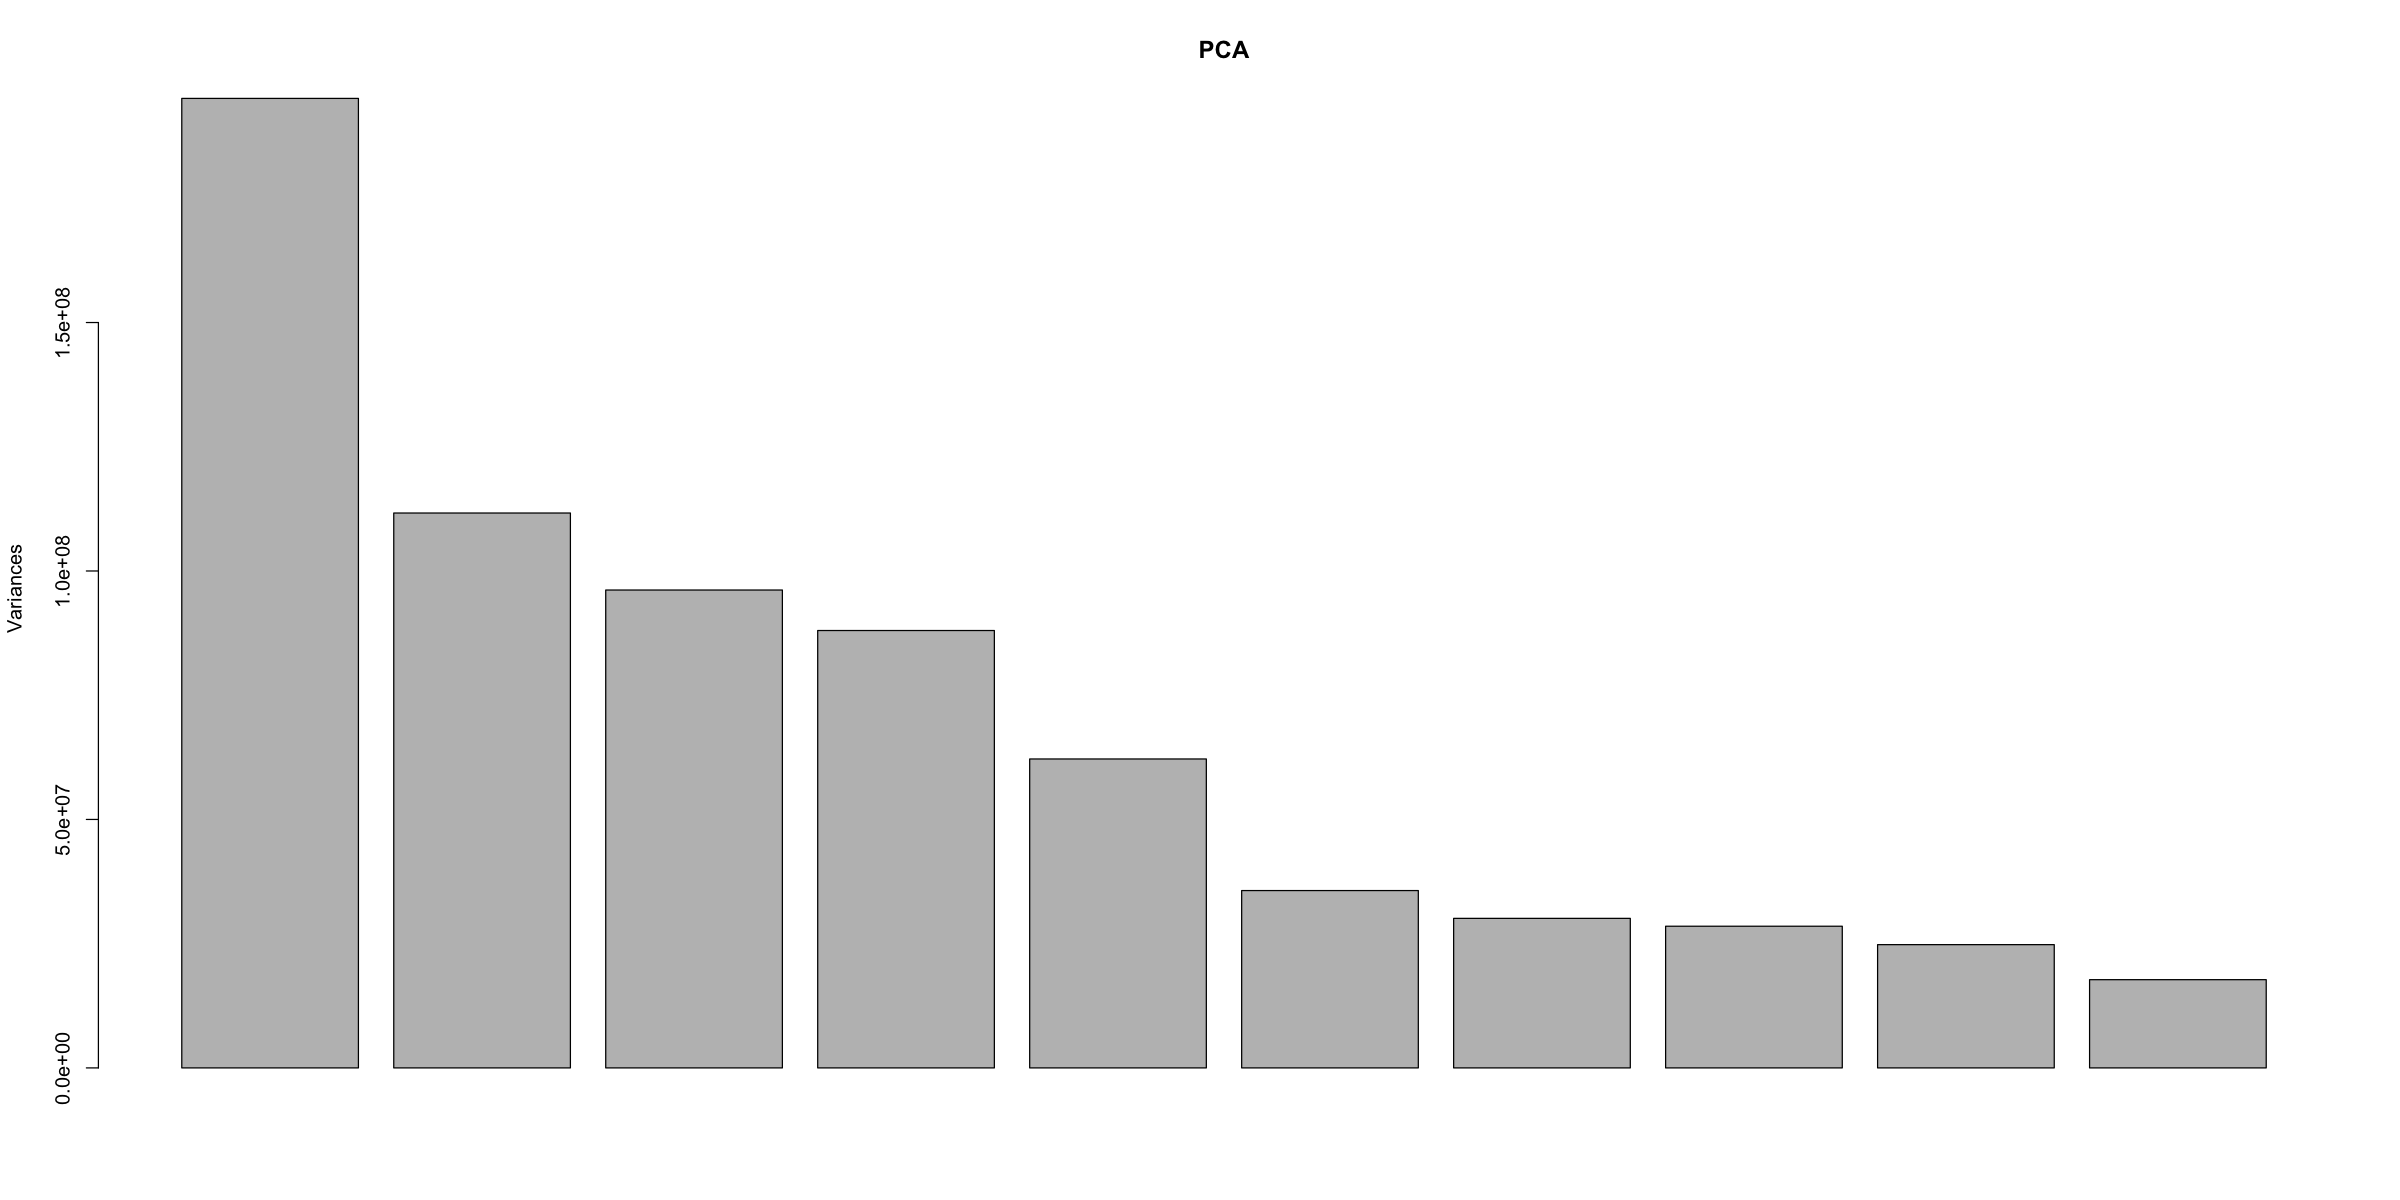

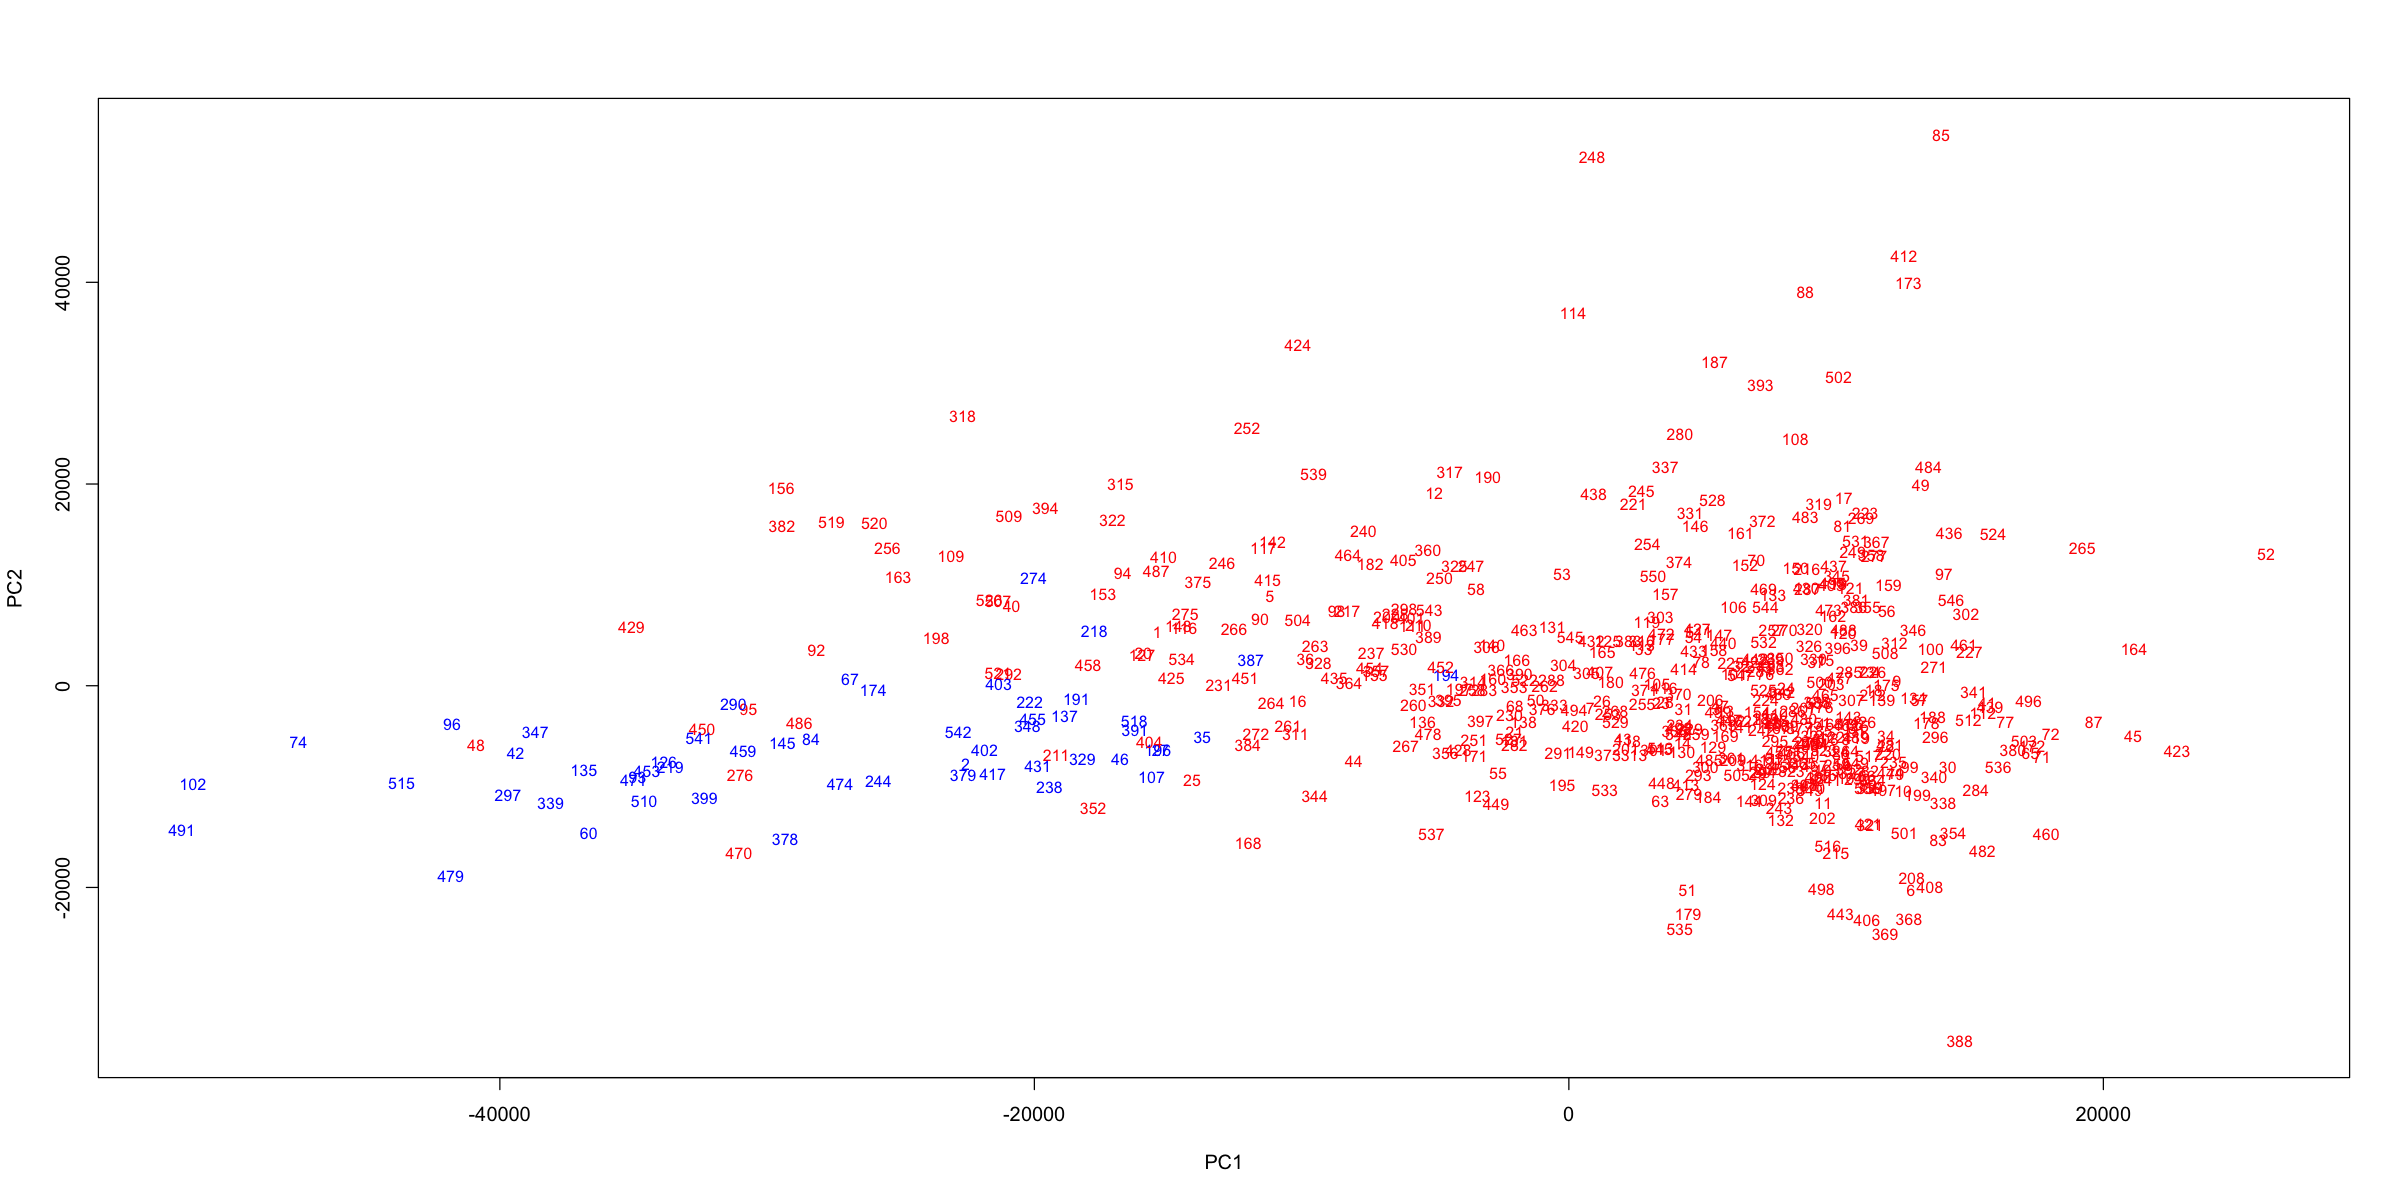

In [84]:
pca <- prcomp(t(all.data_cpm))
col <- ifelse(SampleType == "Solid Tissue Normal", "blue", "red")
plot(pca, main="PCA")
#PC1 & PC2
plot(pca$x[, c(1, 2)], type = 'n')
text(pca$x[, c(1, 2)], label = colnames(all.data_cpm), col = col, cex = 0.8)

## 8. DEG

In [85]:
param_FDR <- 0.05
d <- DGEList(counts = all.data_cpm, group = SampleType)
d <- calcNormFactors(d)
norm.factors <- d$samples$norm.factors/mean(d$samples$norm.factors)#正規化係数の平均が1になるように正規化したものがTCCパッケージで得られるものと同じです

#正規化後のデータをファイルに出力
ef.libsizes <- colSums(all.data_cpm)*norm.factors#effective library sizesというのはlibrary sizesに正規化係数を掛けたものなのでそれを計算した結果をef.libsizesに格納
normalized.count <- sweep(all.data_cpm, 2, mean(ef.libsizes)/ef.libsizes, "*")#正規化後のデータを取り出してnormalized.countに格納

d <- estimateCommonDisp(d)             #the quantile-adjusted conditional maximum likelihood (qCML)法でcommon dispersionを計算している
d <- estimateTagwiseDisp(d)            #the quantile-adjusted conditional maximum likelihood (qCML)法でmoderated tagwise dispersionを計算している
out <- exactTest(d)                    #exact test (正確確率検定)で発現変動遺伝子を計算した結果をoutに格納
#tmp <- topTags(out, n=nrow(data), sort.by="none")#検定結果を抽出
p.value <- out$table$PValue            #p値をp.valueに格納
q.value <- p.adjust(p.value, method="BH")#q値をq.valueに格納
logFC <- out$table$logFC
FC <- 2^logFC
ranking <- rank(p.value)               #p.valueでランキングした結果をrankingに格納
#sum(q.value < param_FDR)               #FDR閾値(q.value < param_FDR)を満たす遺伝子数を表示

#ファイルに保存(テキストファイル)
tmp <- cbind(rownames(all.data_cpm), normalized.count, p.value, q.value,logFC,FC,ranking)#入力データの右側にp.value、q.value、rankingを結合した結果をtmpに格納

DEG<-tmp
upDEG <- rownames(tmp[which((tmp$q.value < param_FDR) & (tmp$FC > 1)),])
downDEG <- rownames(tmp[which((tmp$q.value < param_FDR) & (tmp$FC < 1)),])


## 9. MA plot

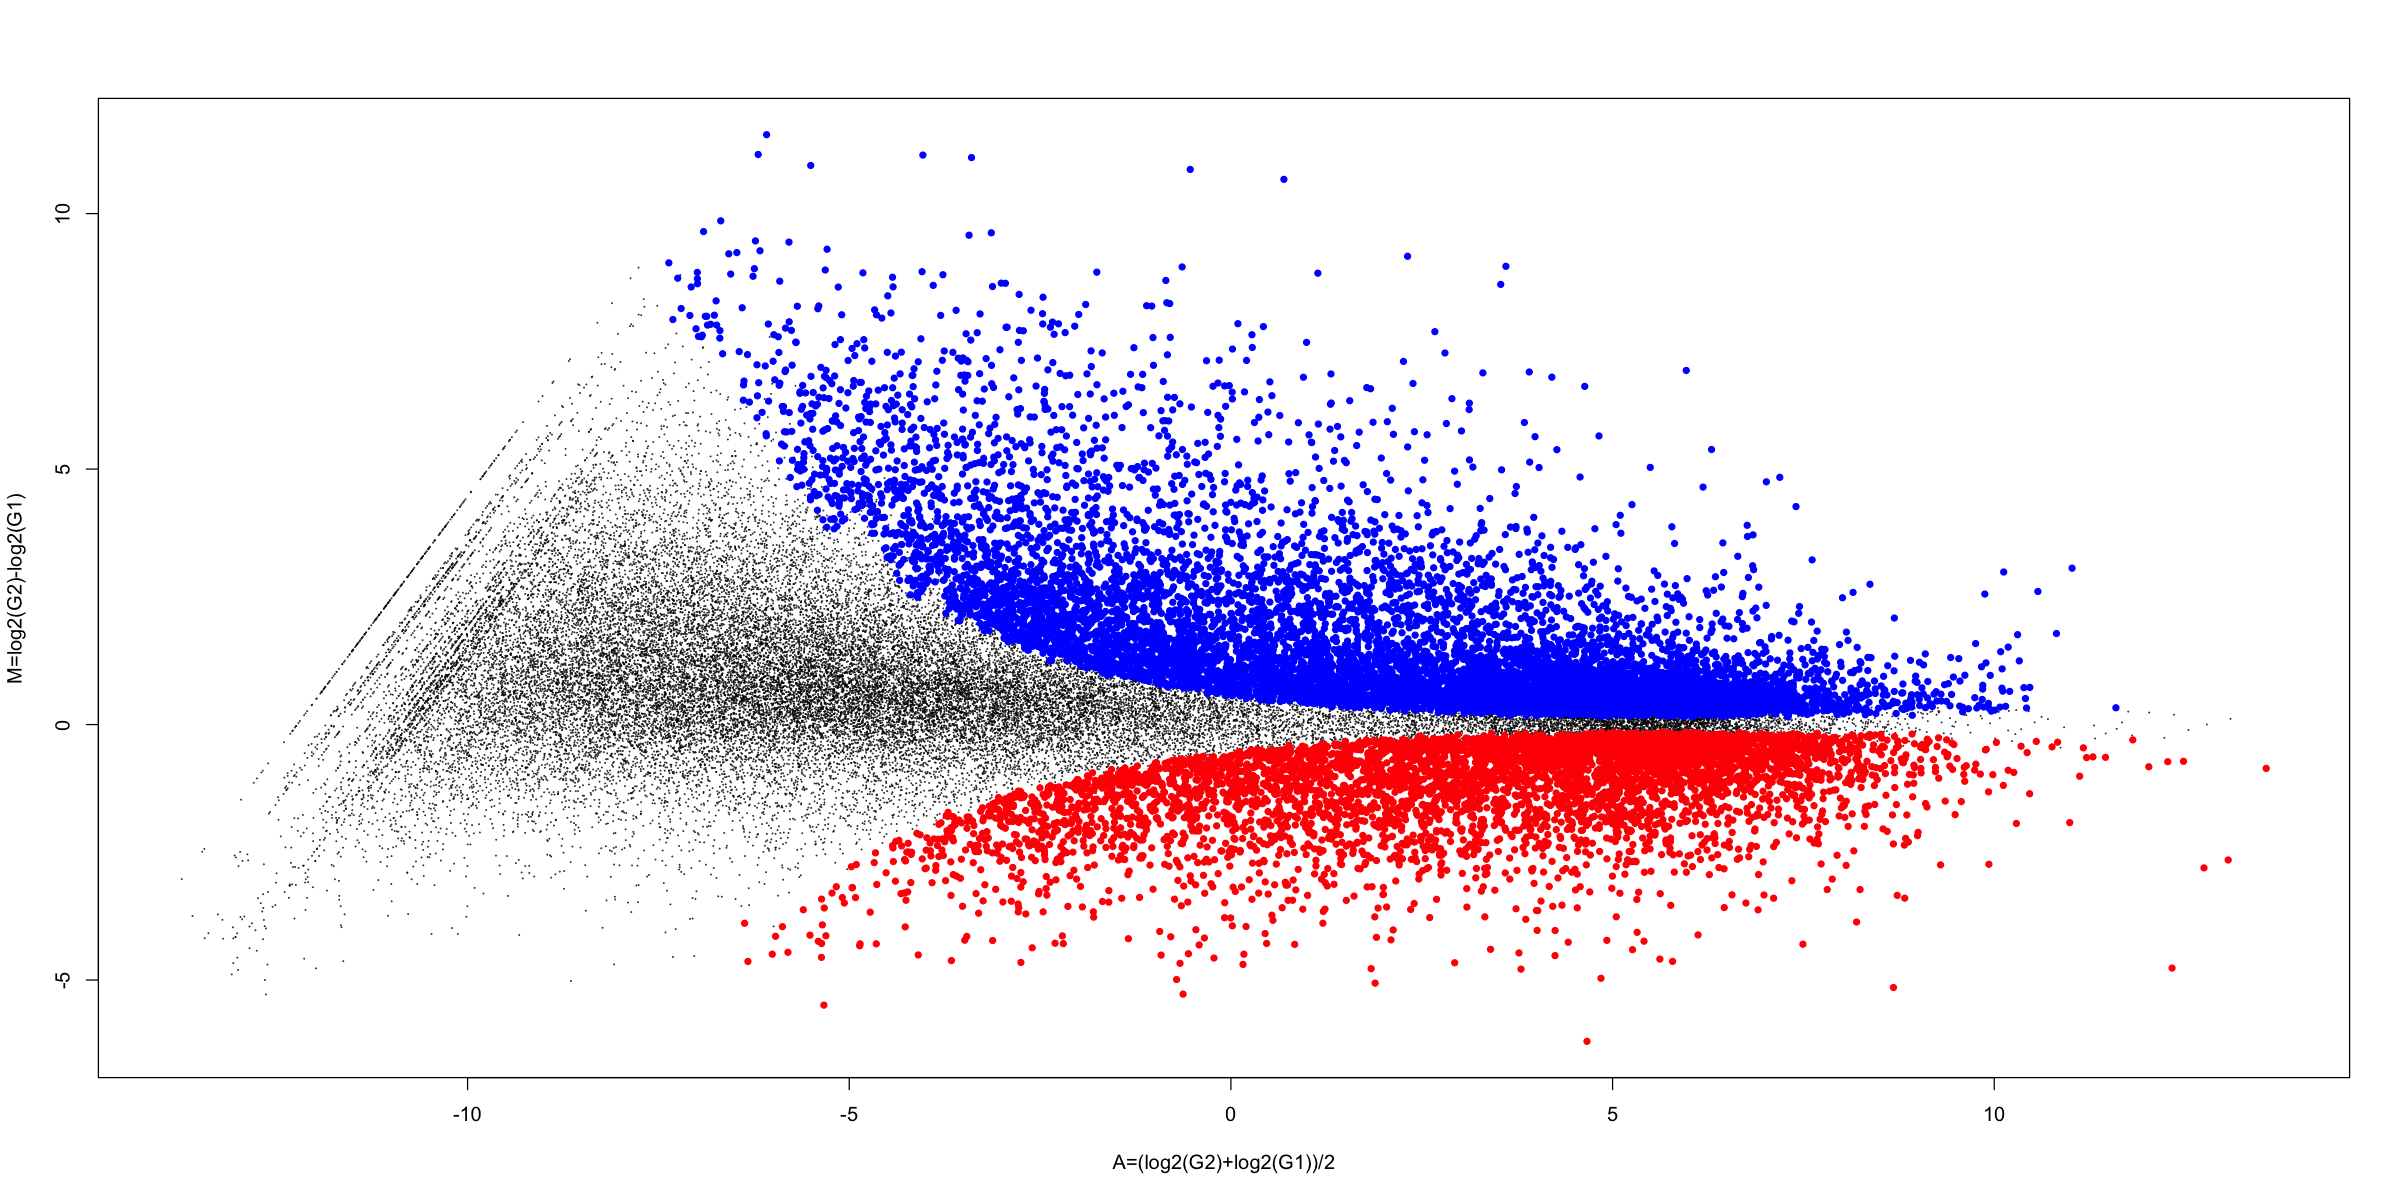

In [86]:
#RPM正規化後のデータでM-A plotを描画（するための基礎情報取得）
D <- DGEList(counts = all.data_cpm, group = SampleType)#DGEListオブジェクトを作成してdに格納
D <- calcNormFactors(D)                #TMM正規化係数を計算
norm_f_TMM <- D$samples$norm.factors   #TMM正規化係数の情報を抽出してnorm_f_TMMに格納
names(norm_f_TMM) <- colnames(all.data_cpm)    #norm_f_TMMのnames属性をcolnames(data)で与えている
effective_libsizes <- colSums(all.data_cpm)*norm_f_TMM #effective library sizesというのはlibrary sizesに(TMM)正規化係数を掛けたものなのでそれを計算した結果をeffective_libsizesに格納
RPM_TMM <- sweep(all.data_cpm, 2, 1000000/effective_libsizes, "*") #元のカウントデータをeffective_libsizesで割り（RPMデータと同程度の数値分布にしたいので）1000000を掛けた正規化後のデータをRPM_TMMに格納

DATA <- RPM_TMM                        #RPM_TMMをdataに格納
mean_G1 <- log2(apply(as.matrix(DATA[,SampleType == "Solid Tissue Normal"]), 1, mean))#遺伝子ごとにG1群の平均の対数を計算した結果をmean_G1に格納
mean_G2 <- log2(apply(as.matrix(DATA[,SampleType == "Primary Tumor"]), 1, mean))#遺伝子ごとにG2群の平均の対数を計算した結果をmean_G2に格納
x_axis <- (mean_G1 + mean_G2)/2        #「G1群の平均値」と「G2群の平均値」の平均をとったものがM-A plotのA(x軸の値)に相当するものなのでx_axisに格納)
y_axis <- mean_G2 - mean_G1            #いわゆるlog比(logの世界での引き算)がM-A plotのM(y軸の値)に相当するものなのでy_axisに格納)
DEG_posi_up <- (q.value < param_FDR & FC > 1)    #指定した閾値未満のものの位置情報をDEG_posiに格納
DEG_posi_down <- (q.value < param_FDR & FC < 1)

plot(x_axis, y_axis, xlab="A=(log2(G2)+log2(G1))/2", ylab="M=log2(G2)-log2(G1)", pch=20, cex=.1)#MA-plotを描画
points(x_axis[DEG_posi_up], y_axis[DEG_posi_up], col="red", pch=20, cex=1)#DEGを赤色にしている
points(x_axis[DEG_posi_down], y_axis[DEG_posi_down], col="blue", pch=20, cex=1)#DEGを青色にしている

## 10. Modification of geneID

In [87]:
uplist <- strsplit(upDEG,"\\.")
up <- c()
for (i in 1:length(upDEG)){
    up[i] <- uplist[[i]][1]
}

downlist <- strsplit(downDEG,"\\.")
down <- c()
for (i in 1:length(downDEG)){
    down[i] <- downlist[[i]][1]
}

## 11. GO (doesn't work because of the excessive number of positive genes)

In [88]:
gostres1 <- gost(up, correction_method = "false_discovery_rate",sources = c("GO", "KEGG", "REAC"),evcodes = TRUE,organism = "hsapiens")

if(length(gostres1)>0){

  g1<-data.frame(gostres1$result$query_size,gostres1$result$intersection_size,gostres1$result$p_value,gostres1$result$term_id,gostres1$result$source,gostres1$result$term_name,gostres1$result$intersection)

  colnames(g1)<-sub("gostres1.result.","",colnames(g1))

  g1<-g1[order(g1$p_value),]
  rownames(g1)<-NULL

  p1 <- gostplot(gostres1,interactive=F,capped=F)
}
print(g1)

gostres2 <- gost(down, correction_method = "false_discovery_rate",sources = c("GO", "KEGG", "REAC"),evcodes = TRUE,organism = "hsapiens")

if(length(gostres2)>0){

  g2<-data.frame(gostres2$result$query_size,gostres2$result$intersection_size,gostres2$result$p_value,gostres2$result$term_id,gostres2$result$source,gostres2$result$term_name,gostres2$result$intersection)

  colnames(g2)<-sub("gostres2.result.","",colnames(g2))

  g2<-g2[order(g2$p_value),]
  rownames(g2)<-NULL

  p2 <- gostplot(gostres2,interactive=F,capped=F)
}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

